# Search Term to Classification Analysis

### Goal: 

- Built a model that gets reasonable micro & macro recall on a test set for the multiple class labels involved. 

### Metrics:

- Recall Overall & Across Classes
  - Micro
  - Macro

### Assumptions

- To figure out what the classes represented, I looked at a couple of the classes and came to the assumption that the classes represent the TYPE of item(s) that are being searched. 
  - I analyzed these 25 at a time.


### Issues

- Special characters are important. For example 3" means "three inches" and these can be entered in any number of ways like " '' " and "inch" and "in".
  - Way to fix this might be to use a custom tokenizer that learns what symbols are grouped together and then have the tokenizer combine the tokens togehter.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
from ydata_profiling import ProfileReport
import modin.pandas as pd
import modin.config as modin_config

modin_config.Engine.put("dask")

/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
conn = sql.connect('../data/grainger.db')
searches_class = pd.read_sql_query("""SELECT * FROM search_terms""", con=conn, dtype=object)

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [3]:
searches_class.describe()

,search_term,class
count,6128528,6128532
unique,5717834,485
top,products,ID_699068447
freq,442,283833


# Sample of Pandas Profiling - Doesn't Work With Large Dataset

In [4]:
# profile = ProfileReport(searches_class.sample(100000), minimal=True)
# profile.to_file('./outputs/profile/raw_data.html')

# Simple Exploration

In [5]:
searches_class.sample(25)

,search_term,class
520101,"bulkhead air fitting,11g338,2019-11-13 14:55:...",ID_478704241
5846546,ductless sp,ID_603406551
4638134,"rheem pressure switch 0.35"" pf spst",ID_832485429
3773803,9w fan motor,ID_680112272
2454892,ss compression tee,ID_946477099
3323492,"1/2"" x 1.25"" reducer",ID_946477099
1249856,3/4 spiral fluted tapered chucking reamer,ID_285483094
1724608,irwin 5/32 screw extractor,ID_787114333
3458309,12 mm compress fitting,ID_946477099
554619,sf-43,ID_6076552


### Class Exploration

In [6]:
# overall searches
class_size = searches_class.groupby('class') \
    .agg(search_term_count=('search_term', 'count')) \
    .sort_values('search_term_count', ascending=True)

# unique searches
class_size_unique = searches_class.groupby('class') \
    .agg(search_term_count=('search_term', 'nunique')) \
    .sort_values('search_term_count', ascending=True)

In [7]:
# all of the raw search texts are unique b/c sum of differences is zero
(class_size['search_term_count'] - class_size_unique['search_term_count']).apply(lambda x: abs(x)).sum()

0

Text(0.5, 0, 'Size of Classes')

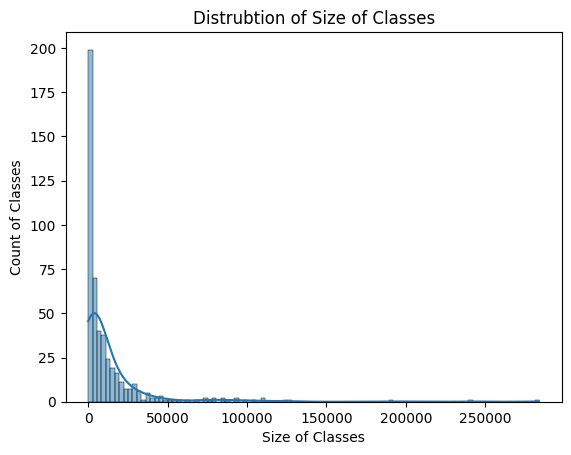

In [8]:
sns.histplot(class_size, legend=False, kde=True)
plt.title("Distrubtion of Size of Classes")
plt.ylabel("Count of Classes")
plt.xlabel("Size of Classes")

In [9]:
# classes vary from size of 283k search terms to one search term
class_size.describe()

,search_term_count
count,485.000000
mean,12636.140206
std,26215.519729
min,1.000000
25%,1248.000000
50%,4258.000000
75%,12274.000000
max,283833.000000


In [10]:
# classes which have only one entry
class_single_entry = class_size[class_size['search_term_count'] <= 3] # 1
display(class_single_entry)

# convert to list for removal
class_single_entry = class_single_entry.index.to_list()

,search_term_count
class,
ID_223719075,1
ID_971210579,1
ID_817600387,1
ID_82032374,1
ID_911331170,3


In [11]:
# remove the classes that have only one entry 
searches_class = searches_class[~searches_class['class'].isin(class_single_entry)]

In [12]:
# remove NAs from X 
searches_class = searches_class.dropna(subset=['search_term'])

### Exploration by Largest, Smallest Class

In [13]:
class_size

,search_term_count
class,
ID_223719075,1
ID_971210579,1
ID_817600387,1
ID_82032374,1
ID_911331170,3
...,...
ID_699945089,124288
ID_40650829,126986
ID_459833412,191248


In [14]:
searches_class[searches_class['class'] == 'ID_40650829'].head(50)

,search_term,class
5,tag mal,ID_40650829
300,the square sign in,ID_40650829
630,brother label maker,ID_40650829
1193,9 sided shape,ID_40650829
1214,striping bar,ID_40650829
1519,slow moving vehicle sign,ID_40650829
1857,label the eye,ID_40650829
2344,asterisk symbol,ID_40650829
2345,detour sign,ID_40650829
2472,brass color,ID_40650829


In [15]:
# how many entries have a special character in them
searches_class['contains_special_char'] = searches_class['search_term'].apply(lambda x: str(x).replace(' ', '').isalnum() == False)

In [16]:
# percent of total entries that contain special characters
searches_class['contains_special_char'].sum() / len(searches_class)

0.2830798817528732

In [17]:
# by classes that contain special characters
special_characters_class = searches_class.groupby('class').agg(n_special_chars=('contains_special_char', 'sum'), n_entries=('contains_special_char', 'count'))
special_characters_class = special_characters_class.sort_values('n_special_chars', ascending=True)
special_characters_class['class_pct_special_chars'] = (special_characters_class['n_special_chars'] / special_characters_class['n_entries'])*100
total_entries = special_characters_class['n_entries'].sum()
special_characters_class['class_total_pct_special_chars'] = (special_characters_class['n_special_chars'] / total_entries)*100

In [18]:
# 22% of each class, on average, contains special characters
special_characters_class.describe()

,n_special_chars,n_entries,class_pct_special_chars,class_total_pct_special_chars
count,480.000000,480.000000,480.000000,480.000000
mean,3614.293750,12767.752083,22.749587,0.058975
std,10324.166782,26320.022781,13.354090,0.168461
min,0.000000,4.000000,0.000000,0.000000
25%,199.750000,1282.250000,13.390248,0.003259
50%,888.500000,4423.000000,18.796025,0.014498
75%,2979.750000,12352.500000,28.221045,0.048621
max,153662.000000,283833.000000,71.289971,2.507326


In [19]:
special_characters_class.columns.to_list()

['n_special_chars',
 'n_entries',
 'class_pct_special_chars',
 'class_total_pct_special_chars']

2023-07-05 03:10:28,440 - distributed.worker - ERROR - Exception during execution of task lambda-47092cd5b1a5593ac016f2fa9bb3ace1.
Traceback (most recent call last):
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/buffer.py", line 184, in __getitem__
    return self.fast[key]
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/common.py", line 127, in wrapper
    return func(*args, **kwargs)
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/zict/lru.py", line 117, in __getitem__
    result = self.d[key]
KeyError: 'apply_list_of_funcs-0522a176-54df-4e17-abd8-a11d15c5e2dc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/programming/miniconda3/envs/grainger/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/home/programming/miniconda3/envs/gr

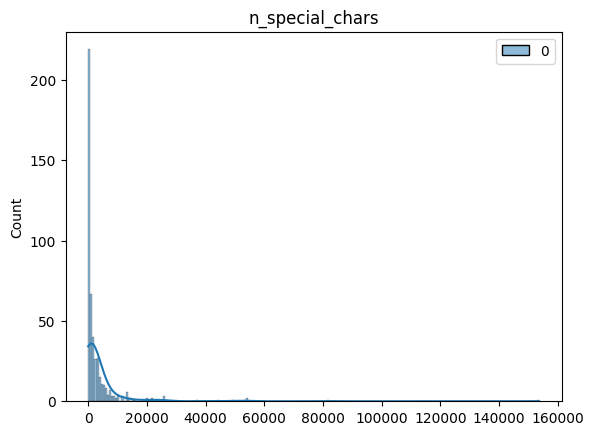

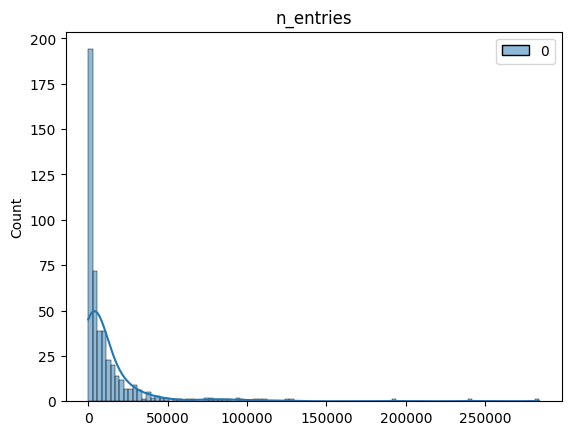

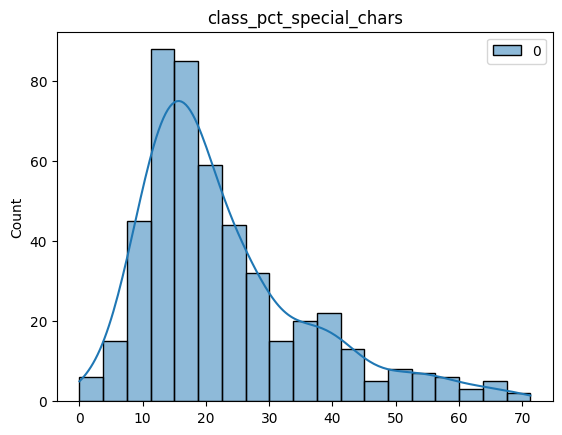

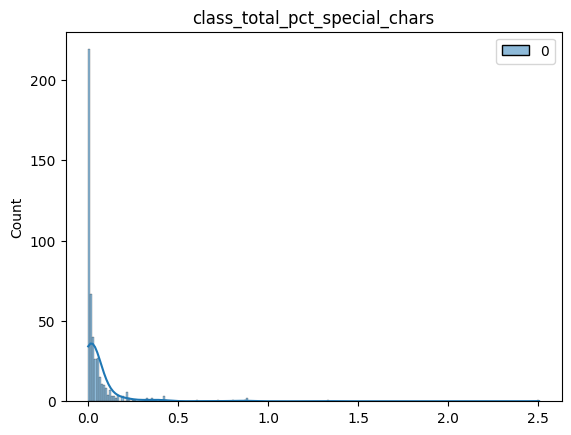

In [20]:
for col in special_characters_class.columns.to_list():
    sns.histplot(special_characters_class[[col]], kde=True)
    plt.title(col)
    plt.show()

# Break Data into Training and Testing Split

In [21]:
# columns of interest
x_col = 'search_term'
y_col = 'class'

from preprocess import split_data, encode_classes, get_stopwords, get_word_occur
from preprocess import SearchAnalyzer
from utils import save_pickle_file

stop_words = get_stopwords()

x_train, x_test, y_train, y_test = split_data(
    x_data=searches_class[x_col],
    y_data=searches_class[y_col], 
    stratify=searches_class['class'], 
    test_size=0.2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/programming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from preprocess import SearchAnalyzer

In [22]:
y_encodings, y_decodings = encode_classes(searches_class[y_col].unique())

In [23]:
# send data to the database
x_train.to_sql('x_train_og', con=conn)
x_test.to_sql('x_test_og', con=conn)

y_train.to_sql('y_train_og', con=conn)
y_test.to_sql('y_test_og', con=conn)

# save out encoding and decodings as pickle files
save_pickle_file(y_encodings, '../data/y_encodings.pkl')
save_pickle_file(y_decodings, '../data/y_decodings.pkl')

1455320                                    m143 metal halide
3050884                                    20x25x2air filter
2829770                                   fs 25 lamp starter
5895206          2 1/2" gravity roller 49" bf 7/16 hex shaft
5546097                       1 1/4" x 1/2" reducer coupling
                                 ...                        
5633023                                         door handles
1749714    13.0 watts plug-in cfl pl-s 2-pin (gx23) 825 l...
5273967                                         wheel 4.00-8
3155102                                        5kcp39hgr272s
2162865                          fp301-1/8-48"-clear-250 pcs
Name: search_term, Length: 4902816, dtype: object

Getting word occurance.


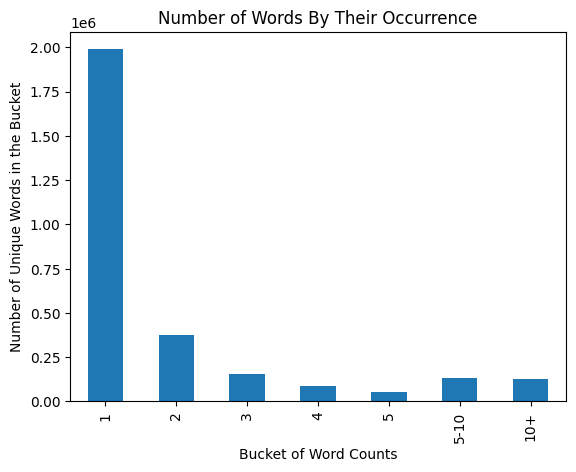

,bucket_count
count_bucket,
1,1987310
2,374569
3,156265
4,86421
5,55758
5-10,133470
10+,126864


In [49]:
analyzer = SearchAnalyzer(
    corpus=x_train,
    stopwords=stop_words
)
analyzer.get_word_occur(ngram_range=(2,2))
analyzer.bin_counts() # standard settings
analyzer.visualize() # also return the dataframe

In [29]:
# get the count of all of the words so that way we can remove anything that is 
# not a frequent enough word for modeling
#word_counts = get_word_occur(x_train, stopwords.words('english'))
word_counts = get_word_occur(x_train, stop_words, ngram_range=(2,2))

# TODO: analysis for multiple engram types (1, 2, 3 )

In [31]:
bin_tuples = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 11), (11, len(word_counts))]
bins = pd.IntervalIndex.from_tuples(bin_tuples)
labels = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '5-10',
    '10+'
]


word_counts['count_bucket'] = pd.cut(word_counts['count'], bins, labels=labels, right=True)#.fillna(leftover_label)
word_counts['count_bucket'].cat.rename_categories(labels, inplace=True)
word_counts['count_bucket']

0          10+
1          10+
2          10+
3          10+
4          10+
          ... 
2920652      1
2920653      1
2920654      1
2920655      1
2920656      1
Name: count_bucket, Length: 2920657, dtype: category
Categories (7, object): ['1' < '2' < '3' < '4' < '5' < '5-10' < '10+']

In [32]:
# get summary count
word_counts = word_counts.groupby('count_bucket').agg(bucket_count=('count_bucket', 'count'))
word_counts

,bucket_count
count_bucket,
1,1987310
2,374569
3,156265
4,86421
5,55758
5-10,133470
10+,126864


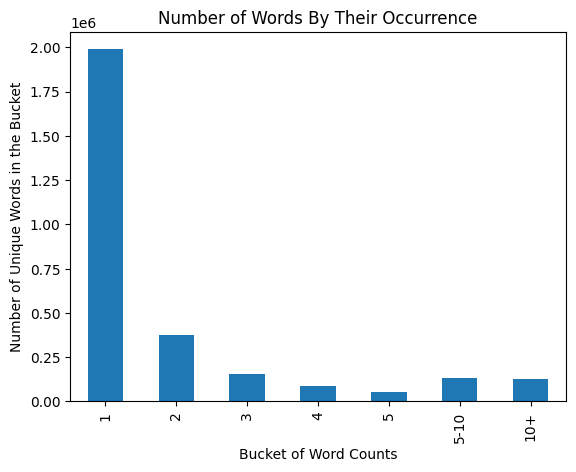

In [33]:
word_counts.plot(kind='bar', legend=False)
plt.xlabel("Bucket of Word Counts")
plt.ylabel("Number of Unique Words in the Bucket")
plt.title("Number of Words By Their Occurrence")
plt.show()

# Count Vectorizer With Limits

In [34]:
cv = CountVectorizer(
    stop_words=stopwords.words('english'), 
    min_df=3 # ignore words that occur less than this in searches
    # max_df= # ignore words that occur MORE than this in the searches
    )
x_train_cvec = cv.fit_transform(list(x_train.values))
x_test_cvec = cv.transform(x_test)

In [35]:
y_train_encode = [y_encodings[i] for i in y_train.to_list()]
y_test_encode = [y_encodings[i] for i in y_test.to_list()]